In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mnist import MNIST
from tqdm import tqdm

In [ ]:
# Adding MNIST dataset
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [3]:
train_images.shape

(60000, 28, 28)

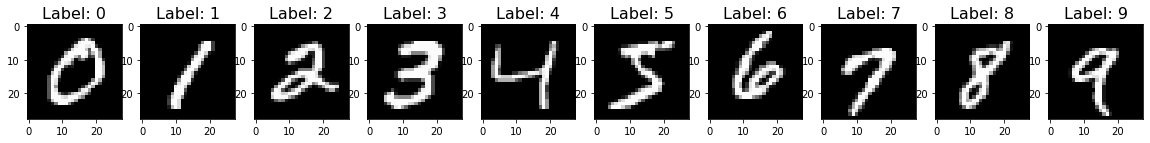

In [4]:
# Data visualization
num_classes = 10

f, ax = plt.subplots(1, num_classes, figsize = (20,20))

for i in range(0, num_classes):
    sample = train_images[train_labels == i][0]
    ax[i].imshow(sample, cmap='gray')
    ax[i].set_title(f'Label: {i}', fontsize=16)

### Define Convolution layer + ReLU activation and its backpropagation

In [5]:
def relu(output):
    '''
    ReLU activation function
    '''
    output[output<=0] = 0
    return output

In [6]:
class Convolution:
# Defining a Convolution layer by using 3x3 filters.

    def __init__(self, num_of_filters):
        self.num_of_filters = num_of_filters

        # filters => (num_filters, 3, 3)
        self.filters = np.random.randn(num_of_filters, 3, 3) / 9

    def generator(self, image):
        '''
        Generator function allows to declare a function that behaves like an iterator
        No padding was used since pytorch.conv2d function's default is also padding = 0
        '''
        height, width = image.shape

        for i in range(height - 2):
            for j in range(width - 2):
                image_region = image[i:(i + 3), j:(j + 3)]
                yield image_region, i, j
    
    def forward(self, input):
        '''
        Forward pass of the convolution layer
        '''
        self.final_input = input

        height, width = input.shape
        # create following matrix for store values of the convolution operation
        output = np.zeros((height - 2, width - 2, self.num_of_filters))

        for image_region, i, j in self.generator(input):
            # multiply elements of two arrays and get 3d array
            # numpy sum fucntion is used to convert it to 1s array which is same length as num_of_filters
            output[i, j] = np.sum(image_region * self.filters, axis=(1, 2))
                    
        # output gives the result of  convolution + ReLU process
        return output

    def backpropagation(self, dL_dout, learning_rate):
        '''
        Backward pass of the convolution layer.
        dL_dout is the loss gradient for this layer's outputs
        '''
        dL_dfilters = np.zeros(self.filters.shape)

        for image_region, i, j in self.generator(self.final_input):
            for f in range(self.num_of_filters):
                dL_dfilters[f] += dL_dout[i, j, f] * image_region

        # Update filters by using Stochastic Gradient Descent
        self.filters -= learning_rate * dL_dfilters

        return None

In [7]:
# Checking the convolutional layer
train_images = mnist.train_images()
train_labels = mnist.train_labels()

convolution = Convolution(32)
output = convolution.forward(train_images[0])

# Output is (26,26,32) because padding was not used
print(output.shape)

(26, 26, 32)


### Define Maxpool layer and its backpropagation

In [8]:
class MaxPool2d:
  # A Max Pooling layer using a pool size of 2.

    def generator(self, image):
        '''
        This generates non-overlapping 2x2 image regions to pool over
        '''
        height, width, _ = image.shape
        new_height = height // 2
        new_width = width // 2

        for i in range(new_height):
            for j in range(new_width):
                image_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield image_region, i, j

    def forward(self, input):
        '''
        Forward pass of the maxpool layer
        '''
        self.last_input = input

        height, width, num_of_filters = input.shape
        # creating a matrix to  to keep the values of maxpool operation
        output = np.zeros((height // 2, width // 2, num_of_filters))

        for image_region, i, j in self.generator(input):
            # each step, numpy.amax returns the maximum value within the window
            output[i, j] = np.amax(image_region, axis=(0, 1))

        return output

    def backpropagation(self, dL_dout):
        '''
        Backward pass of the maxpool layer.
        Output is the loss gradient for this layer's inputs.
        dL_dout is the loss gradient for this layer's outputs.
        '''
        dL_dinput = np.zeros(self.last_input.shape)

        for image_region, i, j in self.generator(self.last_input):
            height, width, f = image_region.shape
            # np.amax return the maximum of an array or maximum along an axis
            amax = np.amax(image_region, axis=(0, 1))

        for i2 in range(height):
            for j2 in range(width):
                for f2 in range(f):
                    # Copying gradient if this pixel is max value
                    if image_region[i2, j2, f2] == amax[f2]:
                        dL_dinput[i * 2 + i2, j * 2 + j2, f2] = dL_dout[i, j, f2]

        return dL_dinput

In [9]:
# Checking convolutional layer + ReLU + maxpool layer
train_images = mnist.train_images()
train_labels = mnist.train_labels()

convolution = Convolution(32)
maxpool = MaxPool2d()

output = convolution.forward(train_images[0])
output = maxpool.forward(output)
print(output.shape)

(13, 13, 32)


### Define fully connected layer with Softmax activation and its backpropagation

In [10]:
class Softmax:
  
    def __init__(self, input_length, nodes):
        self.weights = np.random.randn(input_length, nodes) / input_length
        self.bias = np.zeros(nodes)

    def forward(self, input):
        '''
        Forward pass of the softmax layer
        '''
        self.final_input_shape = input.shape

        input = input.flatten()
        self.final_input = input

        input_length, nodes = self.weights.shape
        
        # values passing to the softmax function
        total = np.dot(input, self.weights) + self.bias
        self.final_total = total

        exp = np.exp(total)
        return exp / np.sum(exp, axis = 0)
 
    def backpropagation(self, dL_dout, learning_rate):
        '''
        Performs a backward pass of the softmax layer.
        Output is the loss gradient for this layer's inputs.
        dL_dout is the loss gradient for this layer's outputs.
        '''
        # Only 1 element of dL_dout will be nonzero
        for i, gradient in enumerate(dL_dout):
            if gradient == 0:
                continue

            # exp^(total)
            expo_t = np.exp(self.final_total)

            # Sum of all expo^(total)
            S = np.sum(expo_t)

            # Gradients of out[i] with respect to total
            dout_dt = -expo_t[i] * expo_t / (S ** 2)
            dout_dt[i] = expo_t[i] * (S - expo_t[i]) / (S ** 2)

            # Gradients of total with respect to weights, bias and input
            dt_dw = self.final_input
            dt_db = 1
            dt_dinput = self.weights

            # Gradients of loss with respect to total
            dL_dt = gradient * dout_dt

            # Gradients of loss with respect to weights, bias and input
            # np.newaxis function is used to create a new axis of length one
            dL_dw = dt_dw[np.newaxis].T @ dL_dt[np.newaxis]
            dL_db = dL_dt * dt_db
            dL_dinput = dt_dinput @ dL_dt

            # Update weights and bias using Stochastic Gradient Descent (SGD)
            self.weights -= learning_rate * dL_dw
            self.bias -= learning_rate * dL_db

            # reshape the output because of the flattening in the forward layer
            return dL_dinput.reshape(self.final_input_shape)

### Training the Convolutional Neural Network

In [11]:
train_images = mnist.train_images()[:30000]
train_labels = mnist.train_labels()[:30000]
test_images = mnist.test_images()[:]
test_labels = mnist.test_labels()[:]

convolution = Convolution(32)
maxpool = MaxPool2d()
softmax = Softmax(13 * 13 * 32, 10)     

def forward(image, label):
    '''
    Completes a forward pass of the CNN
    '''
    # Transform the image from [0, 255] to [-0.5, 0.5] to make it easier to work
    out = convolution.forward((image / 255) - 0.5)
    
    # Pass through the ReLu activation
    out[out<=0] = 0 
    
    out = maxpool.forward(out)
    out = softmax.forward(out)

    # Calculate cross entropy loss
    loss = -np.log(out[label])
    
    # calculating the accuracy
    accuracy = 1 if np.argmax(out) == label else 0

    return out, loss, accuracy

def train(im, label, learning_rate = 0.005):
    '''
    Completes a full training step on the image and label
    Returns the loss and accuracy
    '''
    # Forward
    out, loss, accuracy = forward(im, label)

    # Calculate initial gradient
    # output from the softmax which is vector of 10 probabilities
    # optimizer.zero_grad
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]

    # Backpropagation
    gradient = softmax.backpropagation(gradient, learning_rate)
    gradient = maxpool.backpropagation(gradient)
    
    # backpropagate through ReLU activation
    gradient[gradient<=0] = 0
    gradient = convolution.backpropagation(gradient, learning_rate)

    return loss, accuracy

In [12]:
# 2 dictionaries to store accuracy/epoch and loss/epoch for both train and validation datasets

accuracy_stats = {
    'train': []
}
loss_stats = {
    'train': []
}

In [13]:
print('Begin Training !!!')

# Using 3 epochs to train
for epoch in tqdm(range(3)):
    print('--- Epoch %d ---' % (epoch + 1))

    # Shuffle the training data
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]

    # Training
    loss = 0
    num_of_correct = 0
    
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if i % 100 == 99:
            print(
                '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                (i + 1, loss / 100, num_of_correct)
            )
            loss = 0
            num_of_correct = 0

        l, accuracy = train(im, label)
        loss += l
        num_of_correct += accuracy
        
    loss_stats['train'].append(loss/len(train_images))
    accuracy_stats['train'].append(num_of_correct/len(train_images))

Begin Training !!!



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.236 | Accuracy: 20%
[Step 200] Past 100 steps: Average Loss 2.199 | Accuracy: 25%
[Step 300] Past 100 steps: Average Loss 1.985 | Accuracy: 32%
[Step 400] Past 100 steps: Average Loss 1.909 | Accuracy: 46%
[Step 500] Past 100 steps: Average Loss 1.853 | Accuracy: 51%
[Step 600] Past 100 steps: Average Loss 1.604 | Accuracy: 62%
[Step 700] Past 100 steps: Average Loss 1.759 | Accuracy: 48%
[Step 800] Past 100 steps: Average Loss 1.621 | Accuracy: 60%
[Step 900] Past 100 steps: Average Loss 1.610 | Accuracy: 62%
[Step 1000] Past 100 steps: Average Loss 1.481 | Accuracy: 72%
[Step 1100] Past 100 steps: Average Loss 1.343 | Accuracy: 73%
[Step 1200] Past 100 steps: Average Loss 1.388 | Accuracy: 72%
[Step 1300] Past 100 steps: Average Loss 1.303 | Accuracy: 72%
[Step 1400] Past 100 steps: Average Loss 1.272 | Accuracy: 76%
[Step 1500] Past 100 steps: Average Loss 1.145 | Accuracy: 81%
[Step 1600] Past 100 steps: Average Loss 1.258 |

[Step 13100] Past 100 steps: Average Loss 0.475 | Accuracy: 91%
[Step 13200] Past 100 steps: Average Loss 0.464 | Accuracy: 88%
[Step 13300] Past 100 steps: Average Loss 0.552 | Accuracy: 88%
[Step 13400] Past 100 steps: Average Loss 0.525 | Accuracy: 88%
[Step 13500] Past 100 steps: Average Loss 0.508 | Accuracy: 90%
[Step 13600] Past 100 steps: Average Loss 0.482 | Accuracy: 89%
[Step 13700] Past 100 steps: Average Loss 0.445 | Accuracy: 92%
[Step 13800] Past 100 steps: Average Loss 0.618 | Accuracy: 80%
[Step 13900] Past 100 steps: Average Loss 0.495 | Accuracy: 87%
[Step 14000] Past 100 steps: Average Loss 0.454 | Accuracy: 91%
[Step 14100] Past 100 steps: Average Loss 0.456 | Accuracy: 90%
[Step 14200] Past 100 steps: Average Loss 0.384 | Accuracy: 93%
[Step 14300] Past 100 steps: Average Loss 0.449 | Accuracy: 88%
[Step 14400] Past 100 steps: Average Loss 0.416 | Accuracy: 89%
[Step 14500] Past 100 steps: Average Loss 0.502 | Accuracy: 84%
[Step 14600] Past 100 steps: Average Los

[Step 26000] Past 100 steps: Average Loss 0.295 | Accuracy: 94%
[Step 26100] Past 100 steps: Average Loss 0.359 | Accuracy: 91%
[Step 26200] Past 100 steps: Average Loss 0.339 | Accuracy: 89%
[Step 26300] Past 100 steps: Average Loss 0.462 | Accuracy: 84%
[Step 26400] Past 100 steps: Average Loss 0.352 | Accuracy: 90%
[Step 26500] Past 100 steps: Average Loss 0.217 | Accuracy: 95%
[Step 26600] Past 100 steps: Average Loss 0.282 | Accuracy: 91%
[Step 26700] Past 100 steps: Average Loss 0.332 | Accuracy: 90%
[Step 26800] Past 100 steps: Average Loss 0.216 | Accuracy: 96%
[Step 26900] Past 100 steps: Average Loss 0.343 | Accuracy: 89%
[Step 27000] Past 100 steps: Average Loss 0.264 | Accuracy: 94%
[Step 27100] Past 100 steps: Average Loss 0.320 | Accuracy: 92%
[Step 27200] Past 100 steps: Average Loss 0.318 | Accuracy: 92%
[Step 27300] Past 100 steps: Average Loss 0.478 | Accuracy: 89%
[Step 27400] Past 100 steps: Average Loss 0.184 | Accuracy: 98%
[Step 27500] Past 100 steps: Average Los


 33%|██████████████████████████▋                                                     | 1/3 [31:21<1:02:42, 1881.25s/it]

[Step 30000] Past 100 steps: Average Loss 0.330 | Accuracy: 91%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 0.410 | Accuracy: 91%
[Step 200] Past 100 steps: Average Loss 0.282 | Accuracy: 91%
[Step 300] Past 100 steps: Average Loss 0.284 | Accuracy: 91%
[Step 400] Past 100 steps: Average Loss 0.273 | Accuracy: 95%
[Step 500] Past 100 steps: Average Loss 0.409 | Accuracy: 87%
[Step 600] Past 100 steps: Average Loss 0.244 | Accuracy: 92%
[Step 700] Past 100 steps: Average Loss 0.415 | Accuracy: 89%
[Step 800] Past 100 steps: Average Loss 0.356 | Accuracy: 88%
[Step 900] Past 100 steps: Average Loss 0.279 | Accuracy: 95%
[Step 1000] Past 100 steps: Average Loss 0.385 | Accuracy: 90%
[Step 1100] Past 100 steps: Average Loss 0.250 | Accuracy: 94%
[Step 1200] Past 100 steps: Average Loss 0.245 | Accuracy: 96%
[Step 1300] Past 100 steps: Average Loss 0.246 | Accuracy: 94%
[Step 1400] Past 100 steps: Average Loss 0.342 | Accuracy: 94%
[Step 1500] Past 100 steps: Average Loss 0.346 

[Step 13000] Past 100 steps: Average Loss 0.344 | Accuracy: 90%
[Step 13100] Past 100 steps: Average Loss 0.380 | Accuracy: 91%
[Step 13200] Past 100 steps: Average Loss 0.219 | Accuracy: 97%
[Step 13300] Past 100 steps: Average Loss 0.320 | Accuracy: 90%
[Step 13400] Past 100 steps: Average Loss 0.312 | Accuracy: 90%
[Step 13500] Past 100 steps: Average Loss 0.318 | Accuracy: 91%
[Step 13600] Past 100 steps: Average Loss 0.231 | Accuracy: 92%
[Step 13700] Past 100 steps: Average Loss 0.256 | Accuracy: 92%
[Step 13800] Past 100 steps: Average Loss 0.323 | Accuracy: 91%
[Step 13900] Past 100 steps: Average Loss 0.464 | Accuracy: 84%
[Step 14000] Past 100 steps: Average Loss 0.224 | Accuracy: 93%
[Step 14100] Past 100 steps: Average Loss 0.324 | Accuracy: 89%
[Step 14200] Past 100 steps: Average Loss 0.289 | Accuracy: 89%
[Step 14300] Past 100 steps: Average Loss 0.342 | Accuracy: 90%
[Step 14400] Past 100 steps: Average Loss 0.226 | Accuracy: 96%
[Step 14500] Past 100 steps: Average Los

[Step 25900] Past 100 steps: Average Loss 0.318 | Accuracy: 89%
[Step 26000] Past 100 steps: Average Loss 0.216 | Accuracy: 92%
[Step 26100] Past 100 steps: Average Loss 0.295 | Accuracy: 90%
[Step 26200] Past 100 steps: Average Loss 0.267 | Accuracy: 92%
[Step 26300] Past 100 steps: Average Loss 0.205 | Accuracy: 93%
[Step 26400] Past 100 steps: Average Loss 0.309 | Accuracy: 92%
[Step 26500] Past 100 steps: Average Loss 0.202 | Accuracy: 97%
[Step 26600] Past 100 steps: Average Loss 0.356 | Accuracy: 91%
[Step 26700] Past 100 steps: Average Loss 0.273 | Accuracy: 90%
[Step 26800] Past 100 steps: Average Loss 0.162 | Accuracy: 95%
[Step 26900] Past 100 steps: Average Loss 0.279 | Accuracy: 90%
[Step 27000] Past 100 steps: Average Loss 0.149 | Accuracy: 97%
[Step 27100] Past 100 steps: Average Loss 0.247 | Accuracy: 93%
[Step 27200] Past 100 steps: Average Loss 0.241 | Accuracy: 92%
[Step 27300] Past 100 steps: Average Loss 0.242 | Accuracy: 93%
[Step 27400] Past 100 steps: Average Los


 67%|█████████████████████████████████████████████████████▎                          | 2/3 [1:02:12<31:03, 1863.34s/it]

[Step 30000] Past 100 steps: Average Loss 0.251 | Accuracy: 92%
--- Epoch 3 ---
[Step 100] Past 100 steps: Average Loss 0.344 | Accuracy: 91%
[Step 200] Past 100 steps: Average Loss 0.317 | Accuracy: 91%
[Step 300] Past 100 steps: Average Loss 0.279 | Accuracy: 91%
[Step 400] Past 100 steps: Average Loss 0.151 | Accuracy: 96%
[Step 500] Past 100 steps: Average Loss 0.414 | Accuracy: 91%
[Step 600] Past 100 steps: Average Loss 0.340 | Accuracy: 90%
[Step 700] Past 100 steps: Average Loss 0.311 | Accuracy: 88%
[Step 800] Past 100 steps: Average Loss 0.161 | Accuracy: 97%
[Step 900] Past 100 steps: Average Loss 0.173 | Accuracy: 95%
[Step 1000] Past 100 steps: Average Loss 0.176 | Accuracy: 95%
[Step 1100] Past 100 steps: Average Loss 0.298 | Accuracy: 92%
[Step 1200] Past 100 steps: Average Loss 0.385 | Accuracy: 89%
[Step 1300] Past 100 steps: Average Loss 0.192 | Accuracy: 95%
[Step 1400] Past 100 steps: Average Loss 0.237 | Accuracy: 95%
[Step 1500] Past 100 steps: Average Loss 0.446 

[Step 13000] Past 100 steps: Average Loss 0.141 | Accuracy: 97%
[Step 13100] Past 100 steps: Average Loss 0.257 | Accuracy: 95%
[Step 13200] Past 100 steps: Average Loss 0.249 | Accuracy: 91%
[Step 13300] Past 100 steps: Average Loss 0.229 | Accuracy: 94%
[Step 13400] Past 100 steps: Average Loss 0.315 | Accuracy: 90%
[Step 13500] Past 100 steps: Average Loss 0.381 | Accuracy: 89%
[Step 13600] Past 100 steps: Average Loss 0.269 | Accuracy: 93%
[Step 13700] Past 100 steps: Average Loss 0.192 | Accuracy: 96%
[Step 13800] Past 100 steps: Average Loss 0.426 | Accuracy: 90%
[Step 13900] Past 100 steps: Average Loss 0.271 | Accuracy: 92%
[Step 14000] Past 100 steps: Average Loss 0.148 | Accuracy: 97%
[Step 14100] Past 100 steps: Average Loss 0.151 | Accuracy: 96%
[Step 14200] Past 100 steps: Average Loss 0.372 | Accuracy: 91%
[Step 14300] Past 100 steps: Average Loss 0.262 | Accuracy: 95%
[Step 14400] Past 100 steps: Average Loss 0.186 | Accuracy: 97%
[Step 14500] Past 100 steps: Average Los

[Step 25900] Past 100 steps: Average Loss 0.296 | Accuracy: 94%
[Step 26000] Past 100 steps: Average Loss 0.248 | Accuracy: 90%
[Step 26100] Past 100 steps: Average Loss 0.317 | Accuracy: 92%
[Step 26200] Past 100 steps: Average Loss 0.255 | Accuracy: 92%
[Step 26300] Past 100 steps: Average Loss 0.310 | Accuracy: 91%
[Step 26400] Past 100 steps: Average Loss 0.411 | Accuracy: 90%
[Step 26500] Past 100 steps: Average Loss 0.241 | Accuracy: 91%
[Step 26600] Past 100 steps: Average Loss 0.200 | Accuracy: 93%
[Step 26700] Past 100 steps: Average Loss 0.517 | Accuracy: 91%
[Step 26800] Past 100 steps: Average Loss 0.196 | Accuracy: 94%
[Step 26900] Past 100 steps: Average Loss 0.205 | Accuracy: 95%
[Step 27000] Past 100 steps: Average Loss 0.249 | Accuracy: 94%
[Step 27100] Past 100 steps: Average Loss 0.239 | Accuracy: 92%
[Step 27200] Past 100 steps: Average Loss 0.191 | Accuracy: 95%
[Step 27300] Past 100 steps: Average Loss 0.278 | Accuracy: 92%
[Step 27400] Past 100 steps: Average Los

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:33:48<00:00, 1876.11s/it]

[Step 30000] Past 100 steps: Average Loss 0.416 | Accuracy: 90%


### Testing the Convolutional Neural Network

In [14]:
loss = 0
num_of_correct = 0
num_of_tests = len(test_images)

for im, label in zip(test_images, test_labels):
    _, l, accuracy = forward(im, label)
    loss += l
    num_of_correct += accuracy

print('Test Loss:', loss / num_of_tests)
print('Test Accuracy:', num_of_correct / num_of_tests)

Test Loss: 0.30123210401327255
Test Accuracy: 0.919


In [15]:
print(num_of_correct)
print(num_of_tests)

9190
10000


313/313 [==============================] - 1s 2ms/step


<AxesSubplot:>

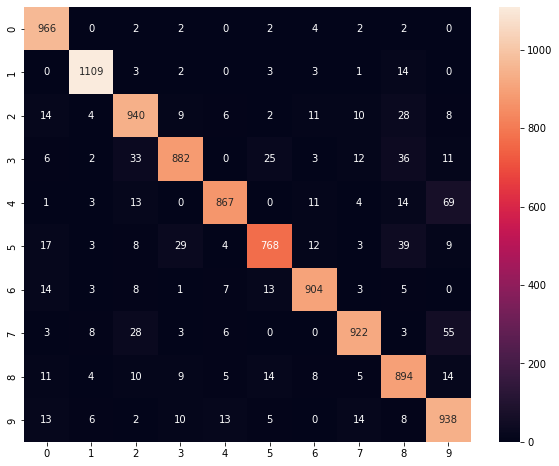

In [28]:
# Predict the values from the testing dataset
pred = model.predict(test_images)
# Convert predictions classes to one hot vectors 
pred_classes = np.argmax(pred,axis = 1) 
# Convert testing observations to one hot vectors
true = np.argmax(test_labels, axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(true, pred_classes) 

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

### Tensorflow Model for MNIST dataset with same parameters

In [17]:
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

In [18]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [19]:
train_images = train_images[:30000]
train_labels = train_labels[:30000]

In [20]:
input_shape = (28, 28, 1)

train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
train_images = train_images / 255
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)
test_images = test_images/255

In [21]:
train_labels = tf.one_hot(train_labels.astype(np.int32), depth=10)
test_labels = tf.one_hot(test_labels.astype(np.int32), depth=10)

In [22]:
batch_size = 64
num_classes = 10
epochs = 3

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-03), loss='categorical_crossentropy', metrics=['acc'])

In [25]:
history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs)

Epoch 1/3
469/469 [==============================] - 4s 8ms/step - loss: 0.6222 - acc: 0.8392
Epoch 2/3
469/469 [==============================] - 4s 8ms/step - loss: 0.3305 - acc: 0.9042
Epoch 3/3
469/469 [==============================] - 4s 9ms/step - loss: 0.3005 - acc: 0.9138


In [31]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test Loss:', np.round(test_loss, 2))
print('Test Accuracy:', np.round(test_acc, 2))

313/313 [==============================] - 1s 2ms/step - loss: 0.2777 - acc: 0.9190
Test Loss: 0.28
Test Accuracy: 0.92
